In [100]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
from keras.models import Sequential
import matplotlib.dates as mdates
from keras.layers import Dense,Dropout
from keras.optimizers import SGD
from sklearn.preprocessing import MinMaxScaler
from keras.layers import GRU

In [101]:
df_eth = pd.read_csv('ETH2019-2024.csv')
df_eth.info()
df_eth.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1815 entries, 0 to 1814
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1815 non-null   int64  
 1   Date        1815 non-null   object 
 2   Open        1815 non-null   float64
 3   High        1815 non-null   float64
 4   Low         1815 non-null   float64
 5   Close       1815 non-null   float64
 6   Adj Close   1815 non-null   float64
 7   Volume      1815 non-null   int64  
dtypes: float64(5), int64(2), object(1)
memory usage: 113.6+ KB


,Unnamed: 0,Date,Open,High,Low,Close,Adj Close,Volume
1810,1810,2024-02-13,2659.586182,2686.455078,2599.169434,2642.185303,2642.185303,18271237044
1811,1811,2024-02-14,2641.685303,2786.893555,2621.025391,2777.902344,2777.902344,21448973822
1812,1812,2024-02-15,2777.601318,2865.845459,2764.010498,2824.378906,2824.378906,23734481937
1813,1813,2024-02-16,2825.480713,2858.450439,2760.331055,2803.691406,2803.691406,17057114638
1814,1814,2024-02-17,2803.735840,2803.735840,2768.312256,2780.726318,2780.726318,18417625088


In [102]:
target_data_eth = df_eth[['Close']]
target_data_eth.head()

,Close
0,136.443619
1,134.206955
2,132.249420
3,127.774124
4,137.822388


In [103]:
scaler = MinMaxScaler(feature_range=(0, 1))
target_data_eth  = scaler.fit_transform(target_data_eth)

In [104]:
# Create training set
test_len  = int(0.3*len(target_data_eth))
train_len = int(0.7*len(target_data_eth))
timesteps = 545
features  = 1

X_train_eth = []
y_train_eth = []

for i in range(timesteps, train_len):
  X_train_eth.append(target_data_eth[i-timesteps:i, :])
  y_train_eth.append(target_data_eth[i, :])

X_train_eth = np.asarray(X_train_eth)
y_train_eth = np.asarray(y_train_eth)

# Reshaping
X_train_eth = np.reshape(X_train_eth, (X_train_eth.shape[0], X_train_eth.shape[1], 1))
print(X_train_eth.shape, y_train_eth.shape)

(725, 545, 1) (725, 1)


In [105]:
X_test_eth = []
y_test_eth = []

for i in range(train_len, target_data_eth.shape[0]):
  X_test_eth.append(target_data_eth[i-timesteps:i, :])
  y_test_eth.append(target_data_eth[i, :])

X_test_eth = np.asarray(X_test_eth)
y_test_eth = np.asarray(y_test_eth)

print(X_test_eth.shape, y_test_eth.shape)

(545, 545, 1) (545, 1)


In [106]:
# The GRU architecture
model_GRU = Sequential()
# First GRU layer with Dropout regularisation
model_GRU.add(GRU(50, return_sequences=True, input_shape=(X_train_eth.shape[1],1), activation='tanh'))
model_GRU.add(Dropout(0.2))
# Second GRU layer
model_GRU.add(GRU(50, return_sequences=True, activation='tanh'))
model_GRU.add(Dropout(0.2))
# Third GRU layer
model_GRU.add(GRU(50, return_sequences=True, activation='tanh'))
model_GRU.add(Dropout(0.2))
# Fourth GRU layer
model_GRU.add(GRU(50, activation='tanh'))
model_GRU.add(Dropout(0.2))
# The output layer
model_GRU.add(Dense(1))

In [107]:
optimizer=SGD(learning_rate=0.01, momentum=0.9)

In [108]:
# Compiling model
model_GRU.compile(optimizer= optimizer,loss='mean_squared_error')
# Fitting to the training set
model_GRU.fit(X_train_eth,y_train_eth,epochs=50,batch_size=150)

Epoch 1/50
5/5 [==============================] - 19s 2s/step - loss: 0.1316
Epoch 2/50
5/5 [==============================] - 13s 2s/step - loss: 0.1008
Epoch 3/50
5/5 [==============================] - 11s 2s/step - loss: 0.0491
Epoch 4/50
5/5 [==============================] - 10s 2s/step - loss: 0.0570
Epoch 5/50
5/5 [==============================] - 11s 2s/step - loss: 0.0332
Epoch 6/50
5/5 [==============================] - 11s 2s/step - loss: 0.0303
Epoch 7/50
5/5 [==============================] - 11s 2s/step - loss: 0.0216
Epoch 8/50
5/5 [==============================] - 11s 2s/step - loss: 0.0146
Epoch 9/50
5/5 [==============================] - 10s 2s/step - loss: 0.0113
Epoch 10/50
5/5 [==============================] - 11s 2s/step - loss: 0.0085
Epoch 11/50
5/5 [==============================] - 11s 2s/step - loss: 0.0063
Epoch 12/50
5/5 [==============================] - 11s 2s/step - loss: 0.0057
Epoch 13/50
5/5 [==============================] - 10s 2s/step - loss: 0.

In [109]:
y_pred_eth_GRU = model_GRU.predict(X_test_eth)
y_pred_eth_GRU = scaler.inverse_transform(y_pred_eth_GRU)
y_test_eth_GRU = scaler.inverse_transform(y_test_eth)

18/18 [==============================] - 6s 204ms/step


In [110]:
# Calculate RMSE
rmse = np.sqrt(np.mean(((y_pred_eth_GRU - y_test_eth_GRU) ** 2)))
print('Root Mean Squared Error:', rmse)

# Calculate MAPE
mape = np.mean(np.abs((y_test_eth_GRU - y_pred_eth_GRU) / y_test_eth_GRU))
print('Mean Absolute Percentage Error (MAPE):', mape)

## Calculate MSE
mse = np.mean((y_pred_eth_GRU - y_test_eth_GRU) ** 2)
print('Mean Squared Error:', mse)

Root Mean Squared Error: 96.645548219886
Mean Absolute Percentage Error (MAPE): 0.04004497680932824
Mean Squared Error: 9340.36199072231


In [95]:
# 13. Dự báo 90 ngày tiếp theo
from numpy import array

x_input = X_test_eth[60:].reshape(1, -1)
x_input.shape

temp_input = list(x_input)
temp_input = temp_input[0].tolist()

lst_output = []
n_steps = 100
i = 0
while(i < 90):

    if(len(temp_input) > 100):
        # Lấy đúng 100 phần tử cuối cùng
        x_input = np.array(temp_input[-100:])
        print("{} day input {}".format(i, x_input))
        x_input = x_input.reshape((1, n_steps, 1))
        # Dự đoán giá trị tiếp theo
        yhat = model_GRU.predict(x_input, verbose=0)
        print("{} day output {}".format(i, yhat))
        # Thêm giá trị dự đoán vào danh sách
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input).reshape((1, n_steps, 1))
        yhat = model_GRU.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.42751527 0.41852423 0.41308425 0.4114833  0.41362696 0.39741659
 0.41472088 0.39355163 0.39363653 0.39406284 0.40468065 0.40660231
 0.38848624 0.41557526 0.41510422 0.41913304 0.41982664 0.41533296
 0.40770371 0.41236624 0.40823798 0.41305071 0.42040663 0.43711715
 0.44307008 0.45360381 0.4643719  0.4511462  0.47792886 0.47817396
 0.47443969 0.47684049 0.44963975 0.44484535 0.45731176 0.4692081
 0.4485249  0.4501391  0.44366341 0.4480859  0.43970537 0.4448184
 0.4528225  0.47132356 0.4676059  0.4583845  0.45984566 0.4511045
 0.48242966 0.47579902 0.46582865 0.46399407 0.46174069 0.47681183
 0.47755809 0.44670091 0.45909618 0.45901304 0.4532654  0.44927542
 0.47270777 0.47521643 0.52568486 0.53366439 0.51342419 0.52451382
 0.50231726 0.51063859 0.52687334 0.51425567 0.50120646 0.50598788
 0.50175317 0.49841889 0.46798451 0.45306573 0.45155041 0.4481788
 0.45870516 0.45885113 0.45658009 0.46931128 0.4751455  0.46196897
 0.46649526 0.46739144 0.4648391  0.46345822 0.4654454

In [96]:
df_eth1 = df_eth.reset_index()['Close']
scaler=MinMaxScaler(feature_range=(0,1))
df_eth1=scaler.fit_transform(np.array(df_eth1).reshape(-1,1))

In [97]:
train_data = df_eth1[:train_len]
test_data = df_eth1[train_len:train_len+test_len]


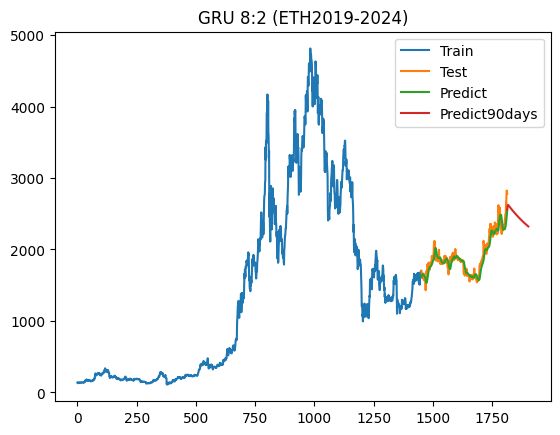

In [99]:
plt.title('GRU 8:2 (ETH2019-2024)')
train_data_index = pd.RangeIndex(start=0, stop=train_len, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_len, stop=train_len+test_len, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_len, stop=train_len+test_len, step=1)
plt.plot(test_data_index,(y_pred_eth_GRU))
prediect_data_index = pd.RangeIndex(start=len(df_eth)-1, stop=len(df_eth)+89, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Predict90days'])
plt.show()